In [1]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from imgaug import augmenters as iaa
import random

In [2]:
dataset_path = './data/'

In [3]:
labels_file = json.loads(open(os.path.join(dataset_path, 'key_data.json'),'r').read())
print('Numbers of sample:', len(labels_file))

Numbers of sample: 5587


Tạo và kiểm tra path cho các ảnh trong dataset thuii.

In [4]:
for index, each_sample in tqdm(enumerate(labels_file), desc='Creating full path', total=len(labels_file)):
    rgb_img_path = os.path.join(dataset_path, 'rgb', '{}_rgb.jpg'.format(each_sample['index']))
    if not os.path.isfile(rgb_img_path):
        print(rgb_img_path, 'not exist. Skipped')
        labels_file.remove(each_sample)
        continue
    depth_img_path = os.path.join(dataset_path, 'depth', '{}_rgb.jpg'.format(each_sample['index']))
    if not os.path.isfile(depth_img_path):
        print(depth_img_path, 'not exist. Skipped')
        labels_file.remove(each_sample)
        continue
    labels_file[index]['rgb_img_path'] = rgb_img_path
    labels_file[index]['depth_img_path'] = depth_img_path

Creating full path: 100%|██████████| 5587/5587 [00:00<00:00, 37688.56it/s]


In [5]:
labels_file

[{'index': 1,
  'angle': 0.0,
  'speed': 100,
  'rgb_img_path': './data/rgb/1_rgb.jpg',
  'depth_img_path': './data/depth/1_rgb.jpg'},
 {'index': 2,
  'angle': 0.0,
  'speed': 100,
  'rgb_img_path': './data/rgb/2_rgb.jpg',
  'depth_img_path': './data/depth/2_rgb.jpg'},
 {'index': 3,
  'angle': 0.0,
  'speed': 100,
  'rgb_img_path': './data/rgb/3_rgb.jpg',
  'depth_img_path': './data/depth/3_rgb.jpg'},
 {'index': 4,
  'angle': 0.0,
  'speed': 100,
  'rgb_img_path': './data/rgb/4_rgb.jpg',
  'depth_img_path': './data/depth/4_rgb.jpg'},
 {'index': 5,
  'angle': 0.0,
  'speed': 100,
  'rgb_img_path': './data/rgb/5_rgb.jpg',
  'depth_img_path': './data/depth/5_rgb.jpg'},
 {'index': 6,
  'angle': 0.0,
  'speed': 100,
  'rgb_img_path': './data/rgb/6_rgb.jpg',
  'depth_img_path': './data/depth/6_rgb.jpg'},
 {'index': 7,
  'angle': 0.0,
  'speed': 100,
  'rgb_img_path': './data/rgb/7_rgb.jpg',
  'depth_img_path': './data/depth/7_rgb.jpg'},
 {'index': 8,
  'angle': 0.0,
  'speed': 100,
  'rgb_im

Augment để còn upsampling nhé

In [6]:
def show_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [7]:
augment_object = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=0.03*255)),
    iaa.Sometimes(0.5, iaa.OneOf([
        iaa.GaussianBlur(sigma=0.5),
        iaa.MotionBlur(angle=(0,360))
    ])),
    iaa.GammaContrast(gamma=(0.5, 1.44)),
    iaa.Sometimes(0.3, iaa.OneOf([
        iaa.FastSnowyLandscape(lightness_threshold=(0,150)),
        iaa.Fog()
    ])),
])

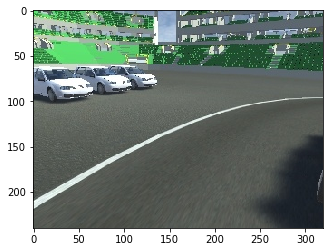

In [8]:
test_img = cv2.imread(random.choice(labels_file)['rgb_img_path'])
show_img(test_img)

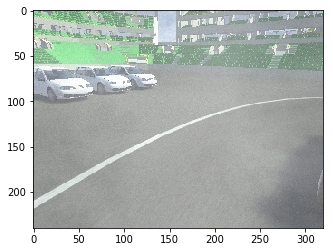

In [9]:
show_img(augment_object.augment_image(test_img))

-60


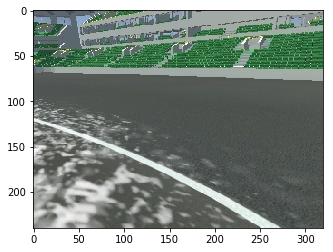

In [45]:
random_sample = random.choice(labels_file)
test_img = cv2.imread(random_sample['rgb_img_path'])
show_img(test_img)
print(random_sample['angle'])

60


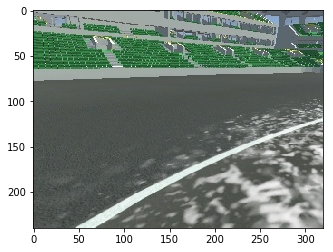

In [46]:
test_img_flip = cv2.flip(test_img, 1)
show_img(test_img_flip)
print(-random_sample['angle'])

In [10]:
def show_distribution(dataset, mode='angle'):
    list_temp = [each[mode] for each in dataset]
    plt.hist(list_temp)

Xem distribution của góc quay 

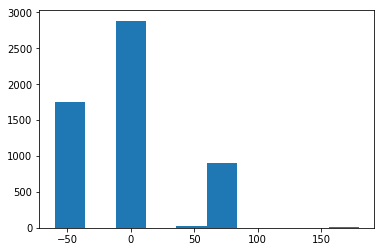

In [11]:
show_distribution(labels_file, 'angle')

Xem distribution của vận tốc

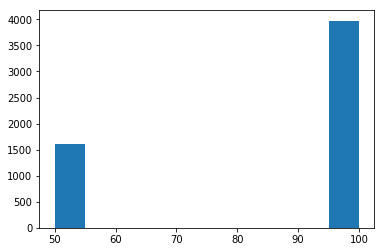

In [12]:
show_distribution(labels_file, 'speed')

Loại hết data khi xe đứng yên

Numbers of sample after remove stop: 5587


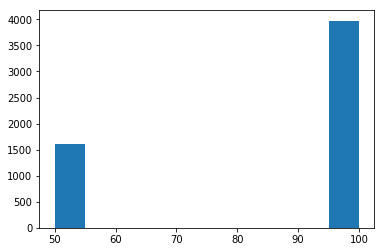

In [13]:
for each_sample in labels_file:
    if each_sample['speed']==0:
        labels_file.remove(each_sample)
print('Numbers of sample after remove stop:', len(labels_file))
show_distribution(labels_file, 'speed')

Upsampling để cân distribution giữa các angle

In [23]:
left_range = (-65, -30)
right_range = (35, 65)

In [52]:
def calculate_angle_amount():
    global left, right, center
    left = right = center = 0
    for each_sample in labels_file:
        if each_sample['angle'] in range(left_range[0], left_range[1]):
            left += 1
        elif each_sample['angle'] in range(right_range[0], right_range[1]):
            right += 1
        else:
            center += 1
    print('Left: {} Right: {} Center: {}'.format(left, right, center))
calculate_angle_amount()

Left: 2339 Right: 2739 Center: 2945


In [53]:
center/left

1.2590850790936297

In [54]:
center/right

1.0752099306316174

In [17]:
def augment_duplicate_upsampling(dataset, src_amount, dst_amount, angle_range):
    new_sample_list = []
    if dst_amount/src_amount < 2:
        percent_need_upsample = int(((dst_amount-src_amount)/2)/src_amount * 100)
        multiplier = 1
    else:
        percent_need_upsample = 101
        multiplier = (dst_amount // src_amount) - 1
    for index, each_sample in tqdm(enumerate(dataset), total=len(dataset)):
        if each_sample['angle'] >= angle_range[0] and each_sample['angle'] <= angle_range[1] and random.randint(0, 100) <= percent_need_upsample:
            for output_index in range(multiplier):
                old_path = each_sample['rgb_img_path']
                org_img = cv2.imread(old_path)            
                new_img = augment_object.augment_image(org_img)
                new_path = rgb_img_path.replace('.jpg','_{}.jpg'.format(output_index))
                cv2.imwrite(new_path, new_img)
                new_sample = {
                    'index': each_sample['index'],
                    'rgb_img_path': new_path,
                    'depth_img_path': each_sample['depth_img_path'],
                    'angle': each_sample['angle'],
                    'speed': each_sample['speed']
                }
                new_sample_list.append(new_sample)
    final_data = new_sample_list + dataset
    print("Numbers of sample after upsampling: ", len(final_data))
    calculate_angle_amount()
    return final_data

In [48]:
def augment_flip_image(dataset, src_amount, dst_amount, angle_range):
    new_sample_list = []
    if dst_amount/src_amount < 2:
        percent_need_upsample = int(((dst_amount-src_amount)/2)/src_amount * 100)
        multiplier = 1
    else:
        percent_need_upsample = 101
        multiplier = (dst_amount // src_amount) - 1
    for index, each_sample in tqdm(enumerate(dataset), total=len(dataset)):
        if each_sample['angle'] >= angle_range[0] and each_sample['angle'] <= angle_range[1] and random.randint(0, 100) <= percent_need_upsample:
            for output_index in range(multiplier):
                old_path = each_sample['rgb_img_path']
                org_img = cv2.imread(old_path)            
                new_img = cv2.flip(org_img, 1)
                new_path = rgb_img_path.replace('.jpg','_{}.jpg'.format(output_index))
                cv2.imwrite(new_path, new_img)
                new_sample = {
                    'index': each_sample['index'],
                    'rgb_img_path': new_path,
                    'depth_img_path': each_sample['depth_img_path'],
                    'angle': -each_sample['angle'],
                    'speed': each_sample['speed']
                }
                new_sample_list.append(new_sample)
    final_data = new_sample_list + dataset
    print("Numbers of sample after upsampling: ", len(final_data))
    calculate_angle_amount()
    return final_data

100%|██████████| 5587/5587 [00:32<00:00, 171.38it/s]

Numbers of sample after upsampling:  7441


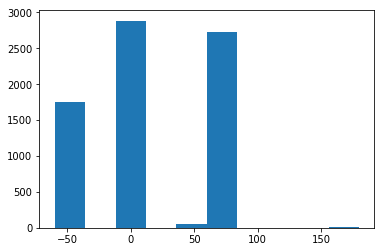

In [18]:
labels_file = augment_duplicate_upsampling(labels_file, right, center, right_range)
show_distribution(labels_file, 'angle')

100%|██████████| 7441/7441 [00:11<00:00, 665.94it/s]  

Numbers of sample after upsampling:  8023


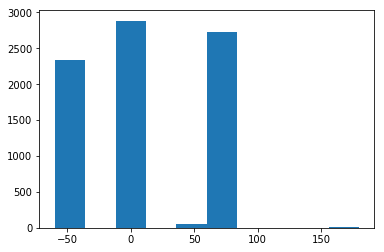

In [20]:
labels_file = augment_duplicate_upsampling(labels_file, left, center, left_range)
show_distribution(labels_file, 'angle')

In [21]:
with open(os.path.join(dataset_path, 'over_sampled_label.json'), 'w', encoding='utf-8') as outfile:
    json.dump(labels_file, outfile, ensure_ascii=False, sort_keys=False, indent=4)
    outfile.write("\n")